It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniotrapote/intro_deep_learning/blob/main/notebooks/Fundamentals/04_IMBD_sentiment_binary_classification.ipynb)
[![View on GitHub](https://img.shields.io/badge/View_on-GitHub-black?logo=github)](https://github.com/antoniotrapote/intro_deep_learning/blob/main/notebooks/Fundamentals/04_IMBD_sentiment_binary_classification.ipynb)




# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
tf.random.set_seed(0)

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [2]:
from tensorflow.keras.datasets import imdb
num_words = 5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [3]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [4]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i,'<UNK>') for i in sentence])
print(get_words(train_data[0], int2word))
print('Sentiment: ', train_labels[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [5]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

### Bag of Words Model BoW
We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}`
- **BoW Normalized**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [6]:
from collections import Counter

def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())

text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


### Document Term Matrix

We need a way to model the documents so that they are all the same length, so that we can use a neural network. For this we are going to use the document term matrix.
- Every document is a vector with the dimension of the vocabulary.
- The position i of the vector corresponds to the word with index i.
- The vector is all zeros except for the BoW word positions, which are filled with the frequency of the corresponding word.


For example:

- D1 = "I like movies",  `{'I': 1, 'like': 1, 'movies': 1}`

- D2 = "I dislike movies",  `{'I': 1, 'dislike': 1, 'movies': 1}`

Then the document-term matrix would be:



   | Doc| I  | like    | dislike   | movies   |
|---:|:-------------|:-----------|:------|:------|
| D1 | 1  | 1       | 0   | 1     |
| D2 | 1  | 0    | 1   | 1     |

$D1 = [1,1,0,1]$

$D2 = [1,0,1,1]$

We convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [7]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 5003), (25000,))

## Define and train a model

Define, compile and fit your NN model

1. You can use the [Functional API](https://keras.io/guides/functional_api/):

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
    layer_1 = layers.Dense(...)(inputs)
```

and the network outputs:
```python
outputs = layers.Dense(...)(previous_layer)
model = keras.Model(inputs=inputs, outputs=outputs)
```

2. Or you can use [Sequential API](https://keras.io/guides/sequential_model/)

```python
model = keras.Sequential(name='example_model')
model.add(layers.Dense(..., input_shape=(8,))
model.add(...
```

You can introduce regularization methods seen in [Prevent_Overfitting.ipynb](https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/Prevent_Overfitting.ipynb) like [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout):


```python
tf.keras.layers.Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)
```

With Functional API:
```python
next_layer = layers.Dropout(0.4)(prev_layer)
```
With Sequential:
```python
model.add(layers.Dropout(0.4))
```

First try with only one hidden layer and see the results.

In [ ]:
# Sequentieal model
model = ...

In [56]:
# Funtional API model

# Input layer
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')

# 1st hidden layer
l_1= layers.Dense(16, activation='relu', name='layer_1')(inputs)
l_1 = layers.Dropout(0.5, name='dropout_1')(l_1)

# 2nd hidden layer
l_2= layers.Dense(16, activation='relu', name='layer_2')(l_1)
l_2 = layers.Dropout(0.5, name='dropout_2')(l_2)

# Output layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(l_2)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5003)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 16)             │        80,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,353 (313.88 KB)

 Trainable params: 80,353 (313.88 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # can be 'val_accuracy'
    patience=5,  # if during 5 epochs there is no improvement in `val_loss`, the execution will stop
    restore_best_weights=True,
    verbose=1)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(x_train, y_train,
                    validation_split=0.25,
                    epochs= 50,
                    batch_size=64,
                    callbacks=[es_callback],
                    verbose=0)

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.


### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

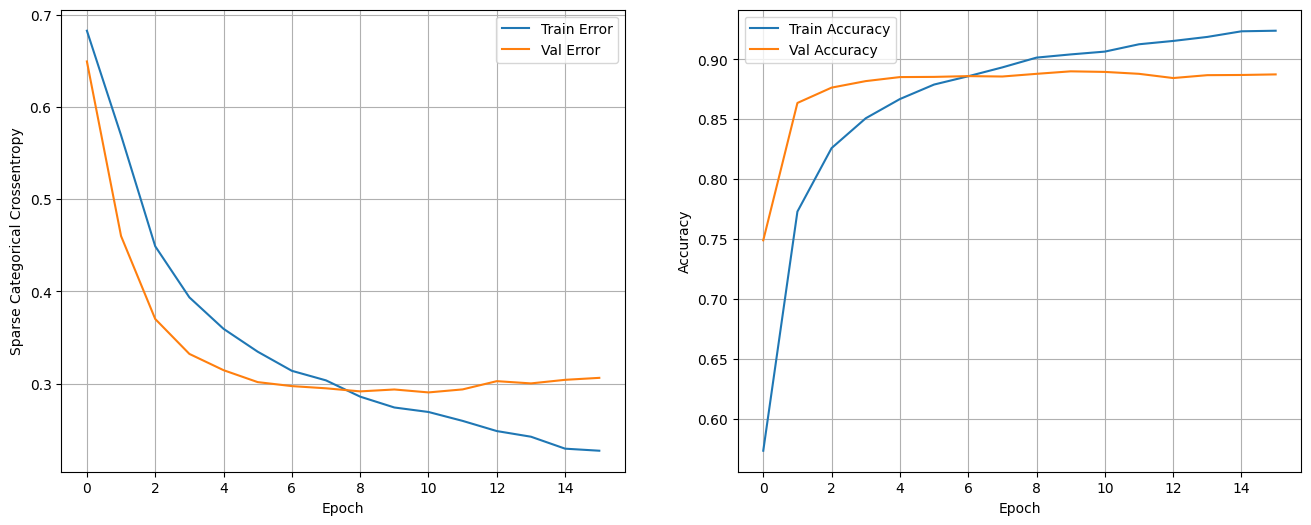

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8855 - loss: 0.2924
Test Loss: 0.2937966585159302
Test Accuracy: 0.8855999708175659


In [58]:
import matplotlib.pyplot as plt
import pandas as pd
def show_loss_accuracy_evolution(hist):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

**Showing Model Errors**

This section of the code defines a function show_errors and then calls that function. The purpose of this function is to display examples of movie reviews from the test dataset where the model made an incorrect prediction regarding the sentiment (positive or negative).

In [59]:
def show_errors(x_test, model, labels, int2word, n_samples=5):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test, model, y_test, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted : 1, real : 0.0, lenght: 184
<START> <UNK> a big struggle as a story that is surreal this movie could've been great as great as it is rated by some here but mixed with the acting director and relatives playing major roles due to financial reasons i <UNK> found in here although calling this acting is not only a stretch of that word it's giving it a new meaning a whole new meaning br br if you are into surreal movies there are some that i do like actually see the japanese strange <UNK> for example you might be able to overlook the flaws see above and enjoy this more there are great ideas here after all many great <UNK> and <UNK> scenes but while watching this with a group of friends almost all of us just couldn't stop laughing not the intention of the director of course again everyone has their own liking as one can see by the high rating of this movie but i could only recommend the movie if you're aware of the work that <UNK> <UNK> has 

### Making predictioins with new data

In [60]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the movie is not bad',
           'the movie is not bad I like it'
]
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
predictions = model.predict(x_pred)
for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

the film was really bad and i am very disappointed
Sentiment:  0.0

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  0.96

this film was just brilliant
Sentiment:  0.95

the movie is not bad
Sentiment:  0.0

the movie is not bad I like it
Sentiment:  0.0


In [61]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]])

### Question 1: Repeat the process with unnormalized bag of words, compare results

In [62]:
x_train = vectorize_sequences(train_data, num_words=num_words, norm=False)
x_test = vectorize_sequences(test_data, num_words=num_words, norm=False)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 5003), (25000,))

In [65]:
# Input layer
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')

# 1st hidden layer
l_1= layers.Dense(16, activation='relu', name='layer_1')(inputs)
l_1 = layers.Dropout(0.5, name='dropout_1')(l_1)

# 2nd hidden layer
l_2= layers.Dense(16, activation='relu', name='layer_2')(l_1)
l_2 = layers.Dropout(0.5, name='dropout_2')(l_2)

# Output layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(l_2)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


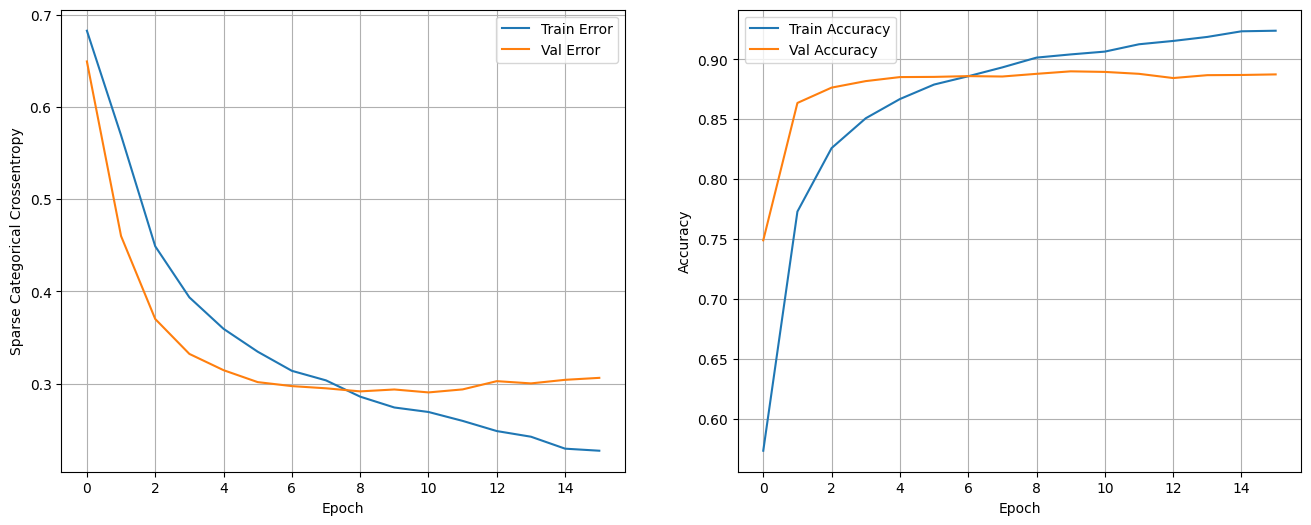

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8786 - loss: 0.2966
Test Loss: 0.29427510499954224
Test Accuracy: 0.879040002822876


In [66]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train,
                    validation_split=0.25,
                    epochs= 50,
                    batch_size=64,
                    callbacks=[es_callback],
                    verbose=0)

show_loss_accuracy_evolution(hist)

results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Question 2: What happens if you reduce the size of the vocabulary `num_words`, compare results

In [67]:
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


((25000, 10003), (25000,))

In [68]:
# Input layer
inputs = tf.keras.Input(shape=(num_words,), name='input_layer')

# 1st hidden layer
l_1= layers.Dense(16, activation='relu', name='layer_1')(inputs)
l_1 = layers.Dropout(0.5, name='dropout_1')(l_1)

# 2nd hidden layer
l_2= layers.Dense(16, activation='relu', name='layer_2')(l_1)
l_2 = layers.Dropout(0.5, name='dropout_2')(l_2)

# Output layer
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(l_2)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs)

Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.


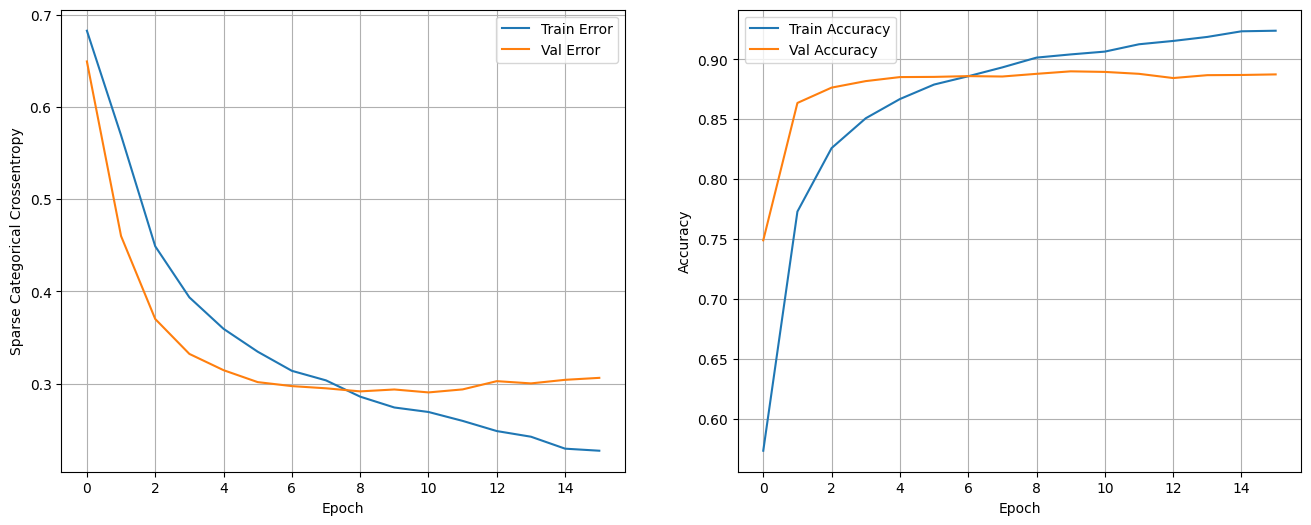

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8859 - loss: 0.2828
Test Loss: 0.2819800078868866
Test Accuracy: 0.8851600289344788


In [69]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train,
                    validation_split=0.25,
                    epochs= 50,
                    batch_size=64,
                    callbacks=[es_callback],
                    verbose=0)

show_loss_accuracy_evolution(hist)

results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [70]:
reviews = [
    'the film was really bad and i am very disappointed',
    'The film was very funny entertaining and good we had a great time . brilliant film',
    'this film was just brilliant', 'the movie is not bad',
    'the movie is not bad I like it'
]
sequences = [
    vectorize_text_sentence(review.lower(), word2int) for review in reviews
]

x_pred = vectorize_sequences(sequences, num_words=num_words)
predictions = model.predict(x_pred)
for review, pred in zip(reviews, predictions.flatten()):
    print()
    print(review)
    print('Sentiment: ', np.round(pred, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

the film was really bad and i am very disappointed
Sentiment:  0.0

The film was very funny entertaining and good we had a great time . brilliant film
Sentiment:  1.0

this film was just brilliant
Sentiment:  1.0

the movie is not bad
Sentiment:  0.0

the movie is not bad I like it
Sentiment:  0.01


### Compare with other ML algorithms

In [71]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
val_acc = clr.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.72424


In [72]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=5, n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.81032


In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(x_train, y_train)
val_acc = rfc.score(x_test, y_test)
print('Test Accuracy: {}'.format(val_acc))

Test Accuracy: 0.84412
